### Basics of Linear Regression ###

What is it?
> I presume that everyone who is looking at this knows what is regression. But, let's start from first principles. If you think about it, regression is really just about trying to find some way to infer y (the dependent variable) from one x (the independent variable) or a number of them. So, let's start from the most common measure of relationships.

**Correlation & Covariance**<br>
These two measures are very similar - the key difference is that correlation deals with variables that have been standardised, but co-variance does not (and so is affected by the scale of variables that you are working with). 

What do you mean by standardisation?

In [1]:
import numpy as np
import numpy.random as npr

# Say you had a series of observations of x drawn from two different generators
x1 = npr.randn(10)
x2 = [npr.randint(100), npr.randint(100), npr.randint(100)]
x = np.hstack((x1,x2))
x

array([-1.22686178e-01, -1.77855485e+00,  8.32336364e-01, -1.06113897e+00,
       -5.76752454e-01,  6.51495778e-02, -1.66875013e+00,  9.87885139e-01,
       -9.78652503e-01, -6.58854803e-01,  6.70000000e+01,  7.10000000e+01,
        6.20000000e+01])

To standardise or normalise them, you simply compute the mean and standard deviation of the the series, and then do this to each of the elements in the series/array so that they are at a similar scale.

In [2]:
def normalise(x):
    return (x-np.mean(x))/np.std(x)

normalise(x)

array([-0.53328412, -0.59166455, -0.4996132 , -0.56637085, -0.54929299,
       -0.52666166, -0.5877932 , -0.49412906, -0.56346265, -0.55218765,
        1.83323887,  1.97426558,  1.65695547])

Even something as simple as normalisation has an immediate application - 
> In credit risk modelling, you often hear about transformation of the risk factors. All that is being done under that is applying such a standardisation and normalisation process to the risk factors being used to build the credit model (so that the scale between all the factors is similar) - We will see this later in subsequent notebooks on regression.

**Covariance**<br>
<br>
$cov(x_i, y) = \frac{1}{n}*\sum{(x_i-\bar{x_i})*(y-\bar{y})}$<br>
<br>
**Correlation**<br>
<br>
$corr(x_i, y) = \frac{1}{n}*\frac{\sum{(x_i-\bar{x_i})*(y-\bar{y})}}{\sigma_{x_i}\sigma_{y}}$<br>
<br>

In [3]:
# Two ways of going about it

# 1. Organically written functions
def covariance(var1, var2, bias=0):
    observations = float(len(var1))
    return np.sum((var1-np.mean(var1))*(var2-np.mean(var2)))/(observations-min(bias, 1))

def correlation(var1,var2,bias=0):
    return covariance(normalise(var1),normalise(var2),bias)

# 2. Using scipy function
from scipy.stats.stats import pearsonr

In [4]:
# First we generate correlated data

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T

In [5]:
correlation(m[0,:], m[1,:])

0.8042625835876421

In [6]:
pearsonr(m[0,:], m[1,:])

(0.8042625835876421, 8.618963256305702e-228)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
x_range = [m[0,:].min(),m[0,:].max()]
y_range = [m[1,:].min(),m[1,:].max()]
x_range, y_range

([-5.975029158142881, 56.60555769589914],
 [-11.194140548845066, 56.00734192592786])

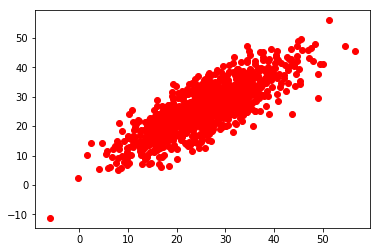

In [8]:
plt.plot(m[0,:], m[1,:], 'ro')

### Primer - Simple Linear Regression ###

Now we more on to regression. 

Sum of squares - general formula <br>
* $ss_{xx} = \sum_{i=1}^{n}(x_i-\bar{x})^2$<br>
* $ss_{yy} = \sum_{i=1}^{n}(y_i-\bar{y})^2$<br>
* $ss_{xy} = \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y})$

Using these variables, we can then plug these into the formula below to find the straight line $y = mx + c$ that minimises the SSE $R^2$<br>

$m = \frac{ss_{xy}}{ss_{xx}}$<br>
$c = \bar{y} - m\bar{x}$

The correlation coefficient, which you will realise is pretty close to the form we had above, is then commonly used to measure how good the fit is. <br>
$r^2 = \frac{ss_{xy}^2}{ss_{xx}ss_{yy}}$

$y = mx + q$ is commonly called a Cartesian formulation and is two dimensional.<br>
If there are multiple dimensions - $y = \beta X + \beta_0$ where y, $\beta$ and X are vectors but the basic principle is the same. <br> 

The above just outlines the most simplistic approach. Most times, we will need to apply iterative procedures which can range from the simple such as Newton-Raphson method to Gradient Descent technique- which we will cover in another notebook.

While we could write our own functions in Python to extend regression to more dimensions, employ more sophisicated iterative procedures, or to go beyond linear relationships, there really is no need to in Python (just as you would not do so in Matlab, R or SPSS). The most established Python libraries in this regard would be the Statsmodels and Scipy/Scikit libraries.

### Statsmodels ###

First, let's try something simple with Statsmodels

Let's use data from Singapore's public data portal - https://data.gov.sg/
I've downloaded the property price index (ppi.csv) and the resale index ('resale.csv'). There is of course a clear relationship between the two, and so it's a good way to illustrate linear regression

In [68]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [69]:
resale = pd.read_csv('resale.csv')

In [70]:
resale.head()

,quarter,index
0,1990-Q1,24.3
1,1990-Q2,24.4
2,1990-Q3,25.0
3,1990-Q4,24.7
4,1991-Q1,24.9


In [71]:
ppi = pd.read_csv('ppi.csv')

In [72]:
ppi.head()

,quarter,level_1,value
0,1975-Q1,Residential Properties,8.9
1,1975-Q2,Residential Properties,9.1
2,1975-Q3,Residential Properties,9.1
3,1975-Q4,Residential Properties,9.1
4,1976-Q1,Residential Properties,9.5


In [73]:
merged = pd.merge(ppi, resale, on='quarter')
merged = merged.drop(['level_1'], axis=1)
merged.columns = ['Quarter', 'Resale Index', 'PPI']

In [74]:
merged.head()

,Quarter,Resale Index,PPI
0,1990-Q1,40.9,24.3
1,1990-Q2,41.8,24.4
2,1990-Q3,42.0,25.0
3,1990-Q4,40.3,24.7
4,1991-Q1,42.1,24.9


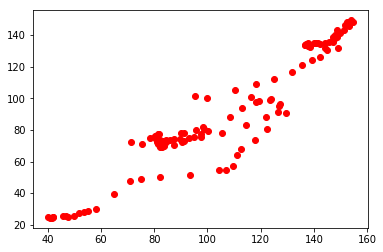

In [36]:
plt.plot(merged['Resale Index'], merged['PPI'], 'ro')

There seems to be a trend (which is exactly what we expected), so let's regress! We will predict the Resale Index(get the y) based on the PPI (i.e. the X).

In [75]:
y = merged['Resale Index']
X = merged['PPI']
X = sm.add_constant(X)

In [45]:
X.head(3)

,const,PPI
0,1.0,24.3
1,1.0,24.4
2,1.0,25.0


In [46]:
# 2 ways of doing this
linear_regression = sm.OLS(y,X)
fitted = linear_regression.fit()

In [47]:
#This might be more familiar to R users
# linear_regression = smf.ols(formula = 'Resale Index~PPI', data=merged)
# fitted = linear_regression.fit()

In [48]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Resale Index   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     946.5
Date:                Sat, 15 Sep 2018   Prob (F-statistic):           1.88e-56
Time:                        10:09:14   Log-Likelihood:                -430.50
No. Observations:                 114   AIC:                             865.0
Df Residuals:                     112   BIC:                             870.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.0412      2.633     11.409      0.000      24.824      35.258
PPI            0.8462      0.028     30.766      0.000       0.792       0.901
==============================================================================
Omnibus:                       21.226   Durbin-Watson:                   0.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.512
Skew:                           1.040   Prob(JB):                     1.75e-06
Kurtosis:                       4.120   Cond. No.                         253.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Quick description of key fields -
* Self explanatory - Dep. Variable, Model, Method, No. Observations
* DF Residuals: # of observations minus the # of parameters
* DF Model: The number of estimated parameters in the model (excluding the constant term from the count)

* R-squared: This is the coefficient of determination, a measure of how well the regression does with respect to a simple mean.
* Adj. R-squared: This is the coefficient of determination adjusted based on the number of parameters in a model and the number of observations that helped build it.
* F-statistic: This is a measure telling you if, from a statistical point of view, all your coefficients, apart from the bias and taken together, are different from zero. In simple words, it tells you if your regression is really better than a simple average.
* Prob (F-statistic): This is the probability that you got that F-statistic just by lucky chance due to the observations that you have used (such a probability is actually called the p-value of F-statistic). If it is low enough you can be confident that your regression is really better than a simple mean. Usually in statistics and science a test probability has to be equal or lower than 0.05 (a conventional criterion of statistical significance) for having such a confidence.
* AIC: Akaike Information Criterion. AIC is a score that evaluates the model based on the number of observations and the complexity of the model itself. The lesser the AIC score, the better. 
* BIC: Bayesian Information Criterion. It works as AIC, but it presents a higher penalty for models with more parameters.
<hr>
* coef: Estimated coefficient
* std err: Standard error of the estimate of the coefficient
* t: t-statistic value, indicating whether the coefficient's true value is different from zero
* P > |t|: p-value indicating the probability that the coefficient is different from zero by chance
* 95.0% Conf. Interval: Lower and upper values of the coefficient, considering 95% of all the chances of having different observations and so different estimated coefficients
<hr>
* Skewness: Measure of the symmetry of residuals around the mean. If symmetric, the value should be around zero. Positive value indicates a long tail to the right; negative value a long tail to the left.
* Kurtosis: Measure of the shape of the distribution of the residuals. A bell-shaped distribution has a zero measure. A negative value points to a too flat distribution; a positive one has too great a peak.
* Omnibus D'Angostino's test: This is a combined statistical test for skewness and kurtosis.
* Prob(Omnibus): This is the Omnibus statistic turned into a probability.
* Jarque-Bera: This is another test of skewness and kurtosis.
* Prob (JB): This is the JB statistic turned into a probability.
* Durbin-Watson: This is a test for the presence of correlation among the residuals (relevant during analysis of time-based data).
* Cond. No: This is a test for multicollinearity (we will deal with the concept of multicollinearity when working with many predictors).

In [49]:
# Recall the previous discussion on correlation. R-squared can be computed as follows.
fitted_values = fitted.predict(X)
mean_sum_squared_errors = np.sum((merged['Resale Index']-merged['Resale Index'].mean())**2)
regr_sum_squared_errors = np.sum((merged['Resale Index']-fitted_values)**2)

(mean_sum_squared_errors-regr_sum_squared_errors) / mean_sum_squared_errors

0.8941928241626816

In [50]:
(pearsonr(merged['PPI'], merged['Resale Index'])[0])**2

0.8941928241626816

Visualisation of residuals

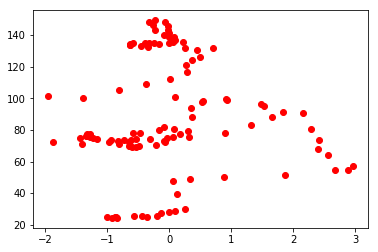

In [51]:
residuals = merged['Resale Index']-fitted_values
normalised_residuals = normalise(residuals)
plt.plot(normalised_residuals, merged['PPI'], 'ro')
# Note the clustering, and  also the outliers

Now we can use the 'fitted' model to predict and plot the line

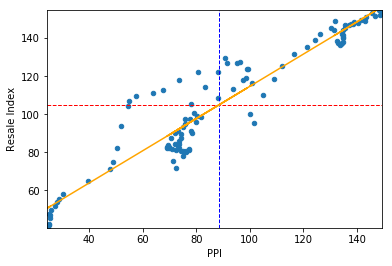

In [54]:
x_range = [merged['PPI'].min(), merged['PPI'].max()]
y_range = [merged['Resale Index'].min(), merged['Resale Index'].max()]
scatter_plot = merged.plot(kind='scatter', x='PPI', y='Resale Index', xlim=x_range, ylim=y_range)
meanY = scatter_plot.plot(x_range, [merged['Resale Index'].mean(),merged['Resale Index'].mean()], '--', color='red', linewidth=1)
meanX = scatter_plot.plot([merged['PPI'].mean(),merged['PPI'].mean()], y_range, '--', color='blue', linewidth=1)
regression_line = scatter_plot.plot(merged['PPI'], fitted_values, '-', color='orange', linewidth=1.5)

In [55]:
# Dot product - akin to what you would usually use in Matlab
betas = np.array(fitted.params)
fitted_values = fitted.predict(X)
predictions_by_dot_product = np.dot(X,betas)
predictions_by_dot_product[:5]

array([50.60293413, 50.68755041, 51.19524808, 50.94139924, 51.1106318 ])

In [56]:
fitted.predict(X)[:5]

0    50.602934
1    50.687550
2    51.195248
3    50.941399
4    51.110632
dtype: float64

Scikit-learn also offers libraries for regressions. Which one to use is really a matter of context and familiarity. Generally statsmodels is used in for statistical context

In [57]:
from sklearn import linear_model
linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)

In [58]:
observations = len(merged) # of training instances

# From a vector of 506 elements to a 506x1 matrix - which is needed for using X in sklearn
X = merged['PPI'].values.reshape((observations,1)) 
y = merged['Resale Index'].values # y can be a vector

linear_regression.fit(X, y)

//anaconda/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
print("Linear regression coefficient %0.1f; intercept %0.1f" %(linear_regression.coef_, linear_regression.intercept_))

Linear regression coefficient 0.8; intercept 30.0


As before, can use predict or self compute the results of the model

In [62]:
print(linear_regression.predict(X)[:10])

[50.60293413 50.68755041 51.19524808 50.94139924 51.1106318  51.61832947
 51.36448063 51.27986436 51.8721783  53.22603876]


In [63]:
Xp = np.column_stack((X,np.ones(observations)))
v_coef = list(linear_regression.coef_) +[linear_regression.intercept_]
np.dot(Xp,v_coef)[:10]

array([50.60293413, 50.68755041, 51.19524808, 50.94139924, 51.1106318 ,
       51.61832947, 51.36448063, 51.27986436, 51.8721783 , 53.22603876])

What's the key difference between using statsmodels and sklearn?
> * sklearn has less statistical output, BUT
* Will be much faster (as it has been developed for machine learning applications.


### A Finance Example ###

Recall CAPM, where the relationship between risk and returns can be described as -

$$ R_i = R_f + \beta_i(R_{mkt} - R_f) $$

where $R_i$ is the return of security i, and it's beta is $\beta_i$, and $R_f$ is the risk free returns.

Let's generate the stock and market returns 

http://pbpython.com/pandas-list-dict.html

In [64]:
import pandas as pd
from collections import OrderedDict

returns = OrderedDict({'timeperiod': [1,2,3,4,5], 
           'stockreturns': [0.65, 0.03, -0.059, -0.001, 0.0346], 
           'marketreturns': [0.055, -0.09, -0.041, 0.045, 0.022]})

table = pd.DataFrame(returns)

In [65]:
table

,timeperiod,stockreturns,marketreturns
0,1,0.6500,0.055
1,2,0.0300,-0.090
2,3,-0.0590,-0.041
3,4,-0.0010,0.045
4,5,0.0346,0.022


To find the beta of a stock's returns, given market returns, we apply linear regression, based on the following equation

$$ r_i = \alpha + \beta r_M$$

In [66]:
# Linear Regression

from scipy import stats

beta, alpha, r_value, p_value, std_err = \
stats.linregress(table['stockreturns'], table['marketreturns'])

In [67]:
print('The beta is {:.2f}'.format(beta))

The beta is 0.11
